# Differentially Private Telemetry Data Analysis – Non-Private Exploration

This notebook performs **non-private preprocessing and exploratory analysis** on the synthetic telemetry dataset.

It covers:
- Loading the raw telemetry CSV
- Preprocessing (cleaning text, parsing timestamps, adding time features)
- Computing event frequencies
- Computing error rates and z-scores by product type
- Visualizing key distributions and time trends

These results serve as the **ground truth** for later differential privacy experiments.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Use a simple matplotlib style
plt.style.use("default")

# ----------------------------------------------------
# PATH SETUP
# ----------------------------------------------------
# This notebook assumes the following repo structure:
#   <repo_root>/
#       data/
#           raw/
#               synthetic_telemetry_data.csv
#           processed/
#       reports/
#       visuals/
#       notebooks/
#
# If your directories are different, update RAW_DIR, PROC_DIR,
# REPORT_DIR, and VIS_DIR accordingly.
# ----------------------------------------------------

# Detect project root:
# - If we are inside notebooks/, go one level up.
# - Otherwise, use current working directory as root.
if os.path.basename(os.getcwd()) == "notebooks":
    ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
else:
    ROOT_DIR = os.getcwd()

# RAW_DIR: folder where the original CSV lives (change if different)
RAW_DIR = os.path.join(ROOT_DIR, "data", "raw")

# PROC_DIR: folder to store cleaned / processed data
PROC_DIR = os.path.join(ROOT_DIR, "data", "processed")

# REPORT_DIR: folder where summary tables (CSV/JSON) will be saved
REPORT_DIR = os.path.join(ROOT_DIR, "reports")

# VIS_DIR: folder where plots (PNG) will be saved
VIS_DIR = os.path.join(ROOT_DIR, "visuals")

# Make sure the output folders exist
os.makedirs(PROC_DIR, exist_ok=True)
os.makedirs(REPORT_DIR, exist_ok=True)
os.makedirs(VIS_DIR, exist_ok=True)

# RAW_PATH: path to the raw telemetry CSV file.
# If your file has a different name or location, change it here.
RAW_PATH = os.path.join(RAW_DIR, "synthetic_telemetry_data.csv")

# CLEAN_PATH: path where the cleaned CSV will be saved.
CLEAN_PATH = os.path.join(PROC_DIR, "telemetry_clean.csv")

ROOT_DIR, RAW_PATH

Matplotlib is building the font cache; this may take a moment.


('c:\\Users\\jadla\\DSC_180A-Section_B15-Quater_1-Project',
 'c:\\Users\\jadla\\DSC_180A-Section_B15-Quater_1-Project\\data\\raw\\synthetic_telemetry_data.csv')

## 1. Load Raw Telemetry Data

We start from the raw synthetic telemetry CSV provided by the instructor.

In [2]:
# ----------------------------------------------------
# We load the raw synthetic telemetry file from RAW_PATH.
# If this fails, double-check that:
#   - RAW_PATH points to the correct folder/file
#   - The file name matches exactly (including extension).
# ----------------------------------------------------

raw_df = pd.read_csv(RAW_PATH)
print(f"Raw shape: {raw_df.shape}")
raw_df.head()

Raw shape: (152356, 4)


,Product Type,Event Type,Time of Event,User ID
0,C,open,2024-05-14 07:34:33,1a377331f95e
1,E,close,2024-06-17 14:43:26,1866bf611f3d
2,C,close,2024-07-13 05:20:43,51985c68b545
3,D,open,2024-06-11 17:39:05,a0ab7ed6e10b
4,C,save,2024-06-23 18:20:35,26e0c22f0ca0


## 2. Preprocessing

Steps:
1. Strip whitespace from `Product Type`, `Event Type`, and `User ID`.
2. Parse `Time of Event` as a proper datetime.
3. Drop rows with invalid timestamps.
4. Create time-based features:
   - `event_date`
   - `event_hour`
   - `event_dow`
   - `is_weekend`

In [3]:
# ----------------------------------------------------
#   - Clean strings for Product Type, Event Type, User ID
#   - Parse Time of Event into a datetime
#   - Drop rows with invalid timestamps
#   - Add time-based features:
#         event_date  (date)
#         event_hour  (0–23)
#         event_dow   (0=Mon .. 6=Sun)
#         is_weekend  (1 if Sat/Sun)
# ----------------------------------------------------

df = raw_df.copy()

# Clean up string columns: remove extra spaces and ensure everything is str
for col in ["Product Type", "Event Type", "User ID"]:
    df[col] = df[col].astype(str).str.strip()

# Parse timestamp column to datetime; invalid parsings become NaT
df["Time of Event"] = pd.to_datetime(df["Time of Event"], errors="coerce")

# Drop rows where Time of Event could not be parsed
before = len(df)
df = df.dropna(subset=["Time of Event"])
after = len(df)

print(f"Dropped {before - after} rows with invalid timestamps.")
print(f"After timestamp cleaning: {df.shape}")

# Create time-based features
df["event_date"] = df["Time of Event"].dt.date
df["event_hour"] = df["Time of Event"].dt.hour
df["event_dow"] = df["Time of Event"].dt.dayofweek  # 0=Mon..6=Sun
df["is_weekend"] = df["event_dow"].isin([5, 6]).astype(int)

# Reorder columns to keep things organized
df = df[
    [
        "Product Type",
        "Event Type",
        "Time of Event",
        "event_date",
        "event_hour",
        "event_dow",
        "is_weekend",
        "User ID",
    ]
]

df.head()


Dropped 0 rows with invalid timestamps.
After timestamp cleaning: (152356, 4)


,Product Type,Event Type,Time of Event,event_date,event_hour,event_dow,is_weekend,User ID
0,C,open,2024-05-14 07:34:33,2024-05-14,7,1,0,1a377331f95e
1,E,close,2024-06-17 14:43:26,2024-06-17,14,0,0,1866bf611f3d
2,C,close,2024-07-13 05:20:43,2024-07-13,5,5,1,51985c68b545
3,D,open,2024-06-11 17:39:05,2024-06-11,17,1,0,a0ab7ed6e10b
4,C,save,2024-06-23 18:20:35,2024-06-23,18,6,1,26e0c22f0ca0


### Saving the Cleaned CSV

In [4]:
# ----------------------------------------------------
# SAVE CLEANED DATASET
# ----------------------------------------------------
# We save the preprocessed dataset so it can be reused by:
#   - other notebooks
#   - src/summary_stats.py
#   - any DP code in later phases
#
# The file will be saved as:
#   data/processed/telemetry_clean.csv
# If you want a different name, change CLEAN_PATH above.
# ----------------------------------------------------

df.to_csv(CLEAN_PATH, index=False)
print(f"Saved cleaned telemetry data to: {CLEAN_PATH}")


Saved cleaned telemetry data to: c:\Users\jadla\DSC_180A-Section_B15-Quater_1-Project\data\processed\telemetry_clean.csv


## 3. Basic Summary Statistics

We compute:
- Standard descriptive stats (`describe(include="all")`)

In [5]:
summary = df.describe(include="all")
summary

,Product Type,Event Type,Time of Event,event_date,event_hour,event_dow,is_weekend,User ID
count,152356,152356,152356,152356,152356.000000,152356.000000,152356.000000,152356
unique,7,5,NaN,91,NaN,NaN,NaN,137232
top,B,open,NaN,2024-07-14,NaN,NaN,NaN,5c39e06ea129
freq,38325,58306,NaN,1764,NaN,NaN,NaN,11157
mean,NaN,NaN,2024-06-15 14:35:25.601282304,NaN,11.544455,3.003551,0.286907,NaN
min,NaN,NaN,2024-05-01 00:00:37,NaN,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,2024-05-23 23:14:06.249999872,NaN,6.000000,1.000000,0.000000,NaN
50%,NaN,NaN,2024-06-15 16:11:39.500000,NaN,12.000000,3.000000,0.000000,NaN
75%,NaN,NaN,2024-07-08 06:52:49.500000,NaN,18.000000,5.000000,1.000000,NaN
max,NaN,NaN,2024-07-30 23:59:44,NaN,23.000000,6.000000,1.000000,NaN


Lot of $NaN$ values so using different way to calculate summary

Below we compute event counts for each product type:

In [7]:
# Events by Product Type
by_product = (
    df.groupby("Product Type")
      .size()
      .rename("event_count")
      .reset_index()
      .sort_values("event_count", ascending=False)
)
display(by_product)

,Product Type,event_count
1,B,38325
3,D,30531
2,C,28470
0,A,23096
6,Others,15289
5,F,15064
4,E,1581


Below we compute event counts for each event type:

In [13]:
# Events by Event Type
by_event = (
    df.groupby("Event Type")
      .size()
      .rename("event_count")
      .reset_index()
      .sort_values("event_count", ascending=False)
)
display(by_event)

,Event Type,event_count
2,open,58306
0,close,46885
4,save,31963
3,reset,10277
1,error,4925


Below we compute event counts for each date, from 2024-05-01 to 2024-05-05:

In [15]:
# Events per day
df["event_date"] = pd.to_datetime(df["event_date"])
by_day = (
    df.groupby("event_date")
      .size()
      .rename("event_count")
      .reset_index()
      .sort_values("event_date")
)
display(by_day.head())

,event_date,event_count
0,2024-05-01,1653
1,2024-05-02,1637
2,2024-05-03,1627
3,2024-05-04,1692
4,2024-05-05,1632


Below we compute the number of unique users for each product type:

In [17]:
# Unique users per product
users_per_product = (
    df.groupby("Product Type")["User ID"]
      .nunique()
      .rename("unique_users")
      .reset_index()
      .sort_values("unique_users", ascending=False)
)
display(users_per_product)

,Product Type,unique_users
1,B,34541
3,D,27499
2,C,25664
0,A,20804
6,Others,13752
5,F,13579
4,E,1413


### Saving tables as CSV

In [18]:
# ----------------------------------------------------
# REPORT_DIR is the folder where we collect tabular outputs
# (CSV, later maybe JSON) that summarize this dataset.
#
# These files are useful for:
#   - Including in the project report
#   - Feeding into future scripts
#   - Letting the TA quickly inspect stats without rerunning the notebook
# ----------------------------------------------------

summary = df.describe(include="all")
summary.to_csv(os.path.join(REPORT_DIR, "telemetry_summary_statistics.csv"))
by_product.to_csv(os.path.join(REPORT_DIR, "telemetry_event_counts_by_product.csv"), index=False)
by_event.to_csv(os.path.join(REPORT_DIR, "telemetry_event_counts_by_type.csv"), index=False)
by_day.to_csv(os.path.join(REPORT_DIR, "telemetry_events_per_day.csv"), index=False)
users_per_product.to_csv(os.path.join(REPORT_DIR, "telemetry_unique_users_per_product.csv"), index=False)

print("Saved summary tables into reports/")

Saved summary tables into reports/


## 4. Error Rates and Z-Scores by Product Type

We now replicate the analysis described in the project README:

1. Count errors per product type  
2. Count total events per product type  
3. Compute error rate  
4. Compute z-score of each product's error rate across all products  

Mathematically:

- Error count:  
  \[
  \text{ErrorCount}_P = \sum_i \mathbf{1}\{\text{EventType}_i = \text{error}, \text{ProductType}_i = P\}
  \]

- Total count:  
  \[
  \text{TotalCount}_P = \sum_i \mathbf{1}\{\text{ProductType}_i = P\}
  \]

- Error rate:  
  \[
  \text{ErrorRate}_P = \frac{\text{ErrorCount}_P}{\text{TotalCount}_P}
  \]

- Z-score:  
  \[
  Z_P = \frac{\text{ErrorRate}_P - \bar{\text{ErrorRate}}}{\text{SD}(\text{ErrorRate})}
  \]


In [19]:
# Error counts per product
error_counts = (
    df[df["Event Type"] == "error"]
    .groupby("Product Type")
    .size()
    .rename("Error Count")
)

# Total counts per product
total_counts = (
    df.groupby("Product Type")
    .size()
    .rename("Total Count")
)

# Combine
err = pd.concat([error_counts, total_counts], axis=1)
err["Error Count"] = err["Error Count"].fillna(0).astype(int)
err["Total Count"] = err["Total Count"].fillna(0).astype(int)

# Error rate
err["Error Rate"] = err["Error Count"] / err["Total Count"]

# Z-scores (handle degenerate case)
if err["Error Rate"].nunique() > 1:
    err["Error Rate Z-Score"] = zscore(err["Error Rate"])
else:
    err["Error Rate Z-Score"] = 0.0

# Sort by error rate descending
err_sorted = err.sort_values("Error Rate", ascending=False)
err_sorted

,Error Count,Total Count,Error Rate,Error Rate Z-Score
Product Type,,,,
D,2718,30531,0.089024,2.057361
F,769,15064,0.051049,0.710730
Others,477,15289,0.031199,0.006838
B,767,38325,0.020013,-0.389819
E,30,1581,0.018975,-0.426617
A,125,23096,0.005412,-0.907574
C,39,28470,0.001370,-1.050918


### Saving the error/zcore tables

In [20]:
# ----------------------------------------------------
# This table is important:
#   - It gives the "ground truth" error rates and z-scores.
#   - Later, the DP mechanism will try to approximate these
#     with noisy (private) versions.
# ----------------------------------------------------

err_sorted.to_csv(os.path.join(REPORT_DIR, "telemetry_error_rates_zscores.csv"))
print("Saved telemetry_error_rates_zscores.csv in reports/")

Saved telemetry_error_rates_zscores.csv in reports/


## 5. Visualizations

We plot:

- Event type distribution  
- Product type distribution  
- Events per day (time series)  
- Error rate by product type  
- Error rate z-score by product type  


### 1. Event type Distribution

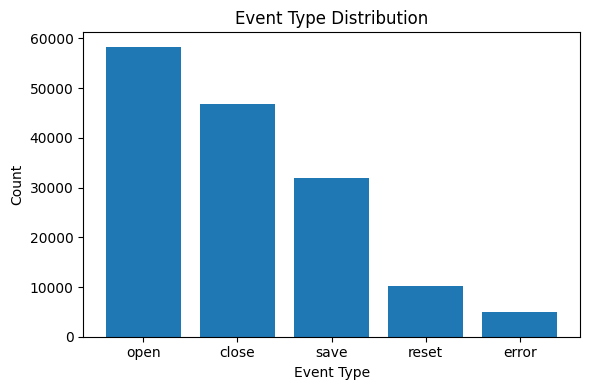

Saved: c:\Users\jadla\DSC_180A-Section_B15-Quater_1-Project\visuals\event_type_distribution.png


In [22]:
# Bar plot of the number of events by Event Type
plt.figure(figsize=(6, 4))
plt.bar(by_event["Event Type"], by_event["event_count"])
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.title("Event Type Distribution")
plt.tight_layout()
path = os.path.join(VIS_DIR, "event_type_distribution.png")
plt.savefig(path, dpi=200)
plt.show()
print(f"Saved: {path}")

### 2. Product type Distribution

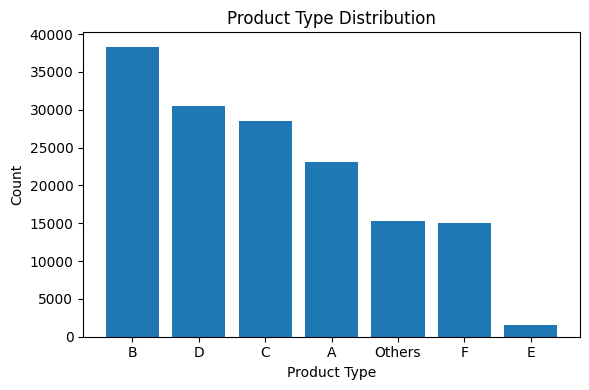

Saved: c:\Users\jadla\DSC_180A-Section_B15-Quater_1-Project\visuals\product_type_distribution.png


In [23]:
# Bar plot of the number of events by Product Type
plt.figure(figsize=(6, 4))
plt.bar(by_product["Product Type"], by_product["event_count"])
plt.xlabel("Product Type")
plt.ylabel("Count")
plt.title("Product Type Distribution")
plt.tight_layout()
path = os.path.join(VIS_DIR, "product_type_distribution.png")
plt.savefig(path, dpi=200)
plt.show()
print(f"Saved: {path}")

### 3. Events Over time Distribution

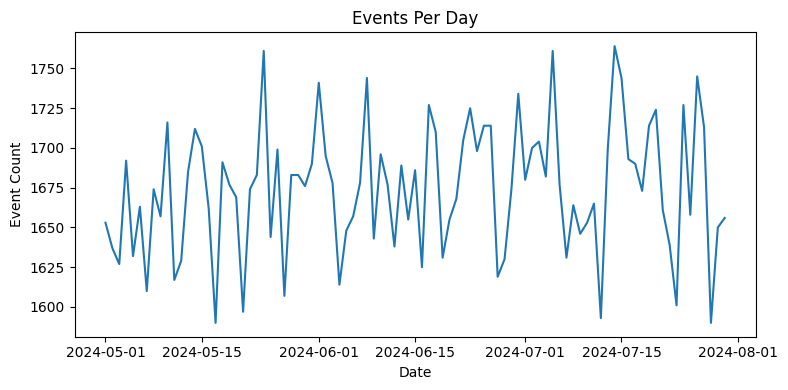

Saved: c:\Users\jadla\DSC_180A-Section_B15-Quater_1-Project\visuals\events_over_time.png


In [24]:
# Bar plot of the number of events by Product Type
plt.figure(figsize=(8, 4))
plt.plot(by_day["event_date"], by_day["event_count"])
plt.xlabel("Date")
plt.ylabel("Event Count")
plt.title("Events Per Day")
plt.tight_layout()
path = os.path.join(VIS_DIR, "events_over_time.png")
plt.savefig(path, dpi=200)
plt.show()
print(f"Saved: {path}")

### 4. & 5. Error rate and z-score per product


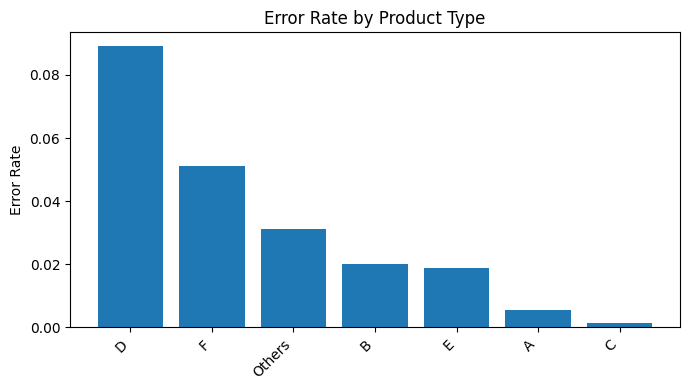

Saved: c:\Users\jadla\DSC_180A-Section_B15-Quater_1-Project\visuals\error_rate_by_product.png


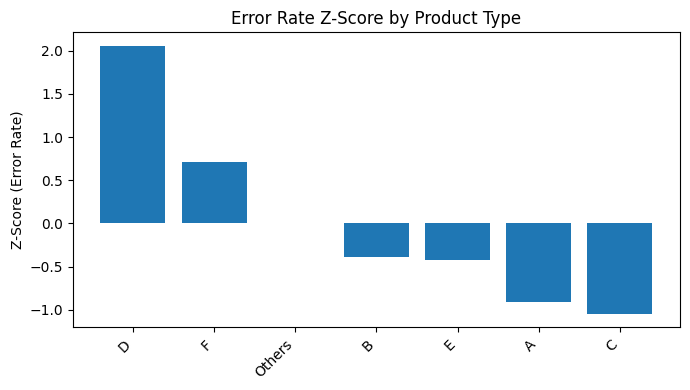

Saved: c:\Users\jadla\DSC_180A-Section_B15-Quater_1-Project\visuals\error_rate_zscore_by_product.png


In [ ]:
# Bar plot: error rate by product type
plt.figure(figsize=(7, 4))
plt.bar(err_sorted.index.astype(str), err_sorted["Error Rate"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Error Rate")
plt.title("Error Rate by Product Type")
plt.tight_layout()
path = os.path.join(VIS_DIR, "error_rate_by_product.png")
plt.savefig(path, dpi=200)
plt.show()
print(f"Saved: {path}")

# Bar plot: z-score of error rate by product type
plt.figure(figsize=(7, 4))
plt.bar(err_sorted.index.astype(str), err_sorted["Error Rate Z-Score"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Z-Score (Error Rate)")
plt.title("Error Rate Z-Score by Product Type")
plt.tight_layout()
path = os.path.join(VIS_DIR, "error_rate_zscore_by_product.png")
plt.savefig(path, dpi=200)
plt.show()
print(f"Saved: {path}")


## 6. Summary

- We loaded and cleaned the synthetic telemetry dataset.
- We created time-based features for later analysis and modeling.
- We computed event frequencies, unique users per product, and daily volumes.
- We computed **error rates** and **z-scores** for each product type.
- We visualized distributions and time trends.

These results form the **non-private ground truth** for later differential privacy experiments, where we will:
- Add noise to user-level counts,
- Recompute DP error rates and z-scores,
- Compare them to these results using $L_\infty$ error and IOU.
